# TEXT CLASSIFICATION USING NAIVE BAYES AND SENTIMENT ANALYSIS ON BLOG POSTS

## 1. Data Exploration and Preprocessing

### •	Load the "blogs_categories.csv" dataset and perform an exploratory data analysis to understand its structure and content.

In [1]:
#import numpy and pandas library
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the dataset
df = pd.read_csv('blogs.csv')
df.head()

,Data,Labels
0,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,alt.atheism
1,Newsgroups: alt.atheism\nPath: cantaloupe.srv....,alt.atheism
2,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,alt.atheism
3,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,alt.atheism
4,Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...,alt.atheism


In [3]:
#Get info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    2000 non-null   object
 1   Labels  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [4]:
#Get Shape
df.shape

(2000, 2)

In [5]:
#Get Missing values
df.isnull().sum()

Data      0
Labels    0
dtype: int64

In [6]:
#Distribution of categories in 'Labels' column
label_counts = df['Labels'].value_counts()
label_counts

Labels
alt.atheism                 100
comp.graphics               100
comp.os.ms-windows.misc     100
comp.sys.ibm.pc.hardware    100
comp.sys.mac.hardware       100
comp.windows.x              100
misc.forsale                100
rec.autos                   100
rec.motorcycles             100
rec.sport.baseball          100
rec.sport.hockey            100
sci.crypt                   100
sci.electronics             100
sci.med                     100
sci.space                   100
soc.religion.christian      100
talk.politics.guns          100
talk.politics.mideast       100
talk.politics.misc          100
talk.religion.misc          100
Name: count, dtype: int64

In [7]:
#Get get text length
df['text_length'] = df['Data'].apply(lambda x: len(str(x)))
#Descriptive statistics for 'text_length' column
df['text_length'].describe()

count     2000.000000
mean      2324.978000
std       3590.560226
min        425.000000
25%       1147.000000
50%       1605.500000
75%       2374.500000
max      62290.000000
Name: text_length, dtype: float64

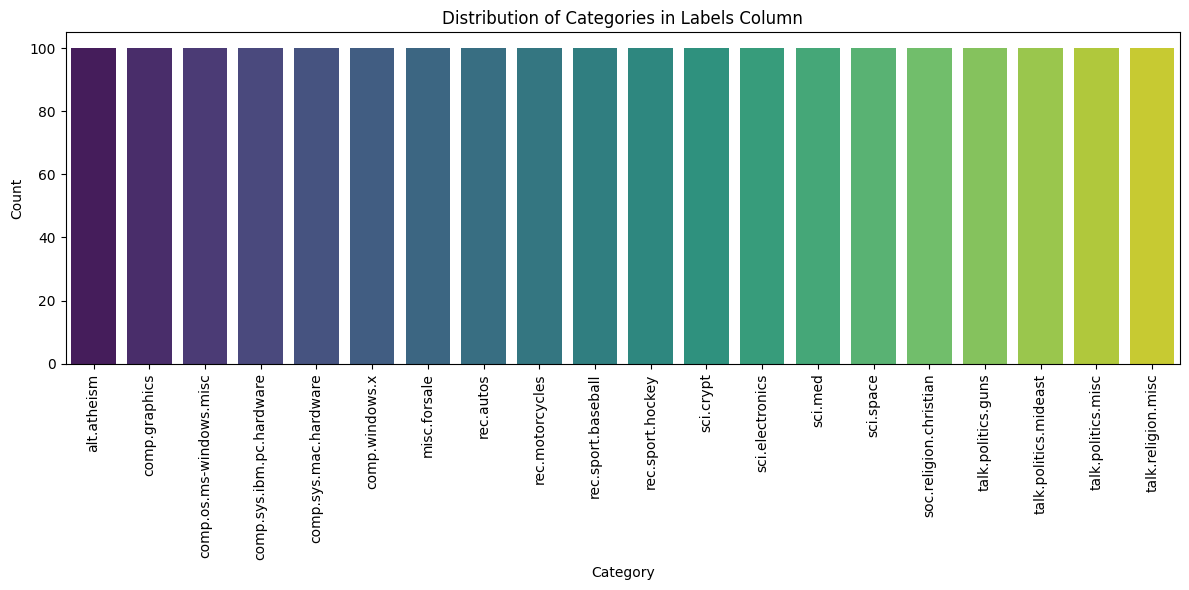

In [8]:
#import visualization library
import matplotlib.pyplot as plt
import seaborn as sns

#draw plot
plt.figure(figsize=(12, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Categories in Labels Column')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

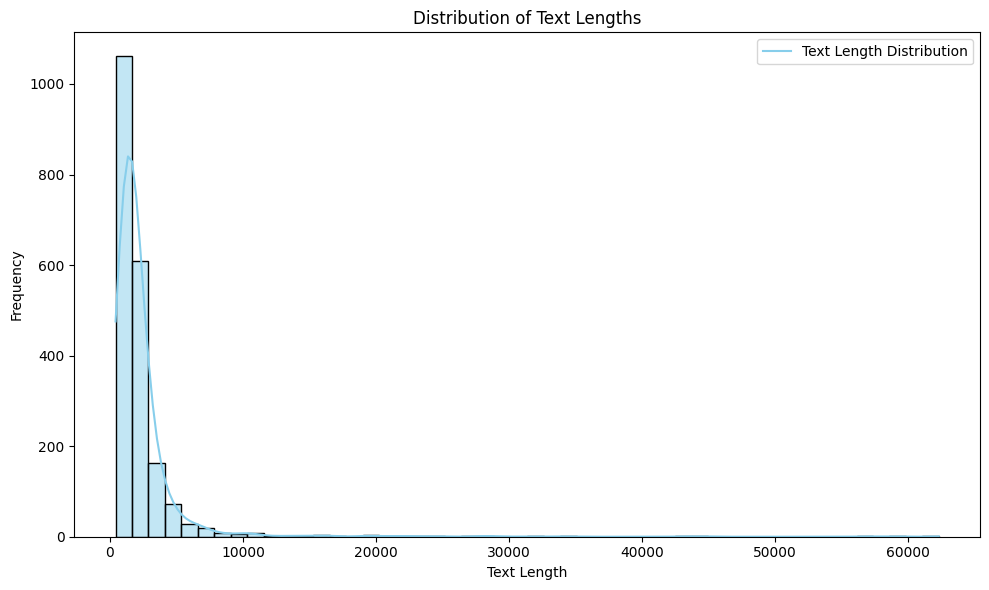

In [10]:
#Draw plot for length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True, color='skyblue')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.legend(['Text Length Distribution'])
plt.tight_layout()
plt.show()

### •	Preprocess the data by cleaning the text (removing punctuation, converting to lowercase, etc.), tokenizing, and removing stopwords.

In [11]:
#import sys,subprocess
import sys
import subprocess

#Download punkt,stopwords
try:
    import nltk
except ImportError:
    print("NLTK not found. Installing NLTK...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "nltk"])
    import nltk

nltk.download('punkt')
nltk.download('stopwords')

#import string
import string
print("NLTK, punkt, stopwords, and string module are ready.")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SURFACE\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SURFACE\AppData\Roaming\nltk_data...


NLTK, punkt, stopwords, and string module are ready.


[nltk_data]   Unzipping corpora\stopwords.zip.


In [12]:
#import nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Function to remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# Apply punctuation removal
df['Data_no_punct'] = df['Data'].apply(remove_punctuation)

# Convert to lowercase
df['Data_lower'] = df['Data_no_punct'].str.lower()

# Tokenize text
def tokenize_text(text):
    return word_tokenize(text)

df['Data_tokens'] = df['Data_lower'].apply(tokenize_text)

# Remove stopwords (case-insensitive)
stop_words = set(stopwords.words('english'))
def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

df['Data_clean'] = df['Data_tokens'].apply(remove_stopwords)

# Display the first few rows of the DataFrame with the new columns
print(df[['Data', 'Data_no_punct', 'Data_lower', 'Data_tokens', 'Data_clean']].head())


                                                Data  \
0  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...   
1  Newsgroups: alt.atheism\nPath: cantaloupe.srv....   
2  Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...   
3  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...   
4  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...   

                                       Data_no_punct  \
0  Path cantaloupesrvcscmuedumagnesiumclubcccmued...   
1  Newsgroups altatheism\nPath cantaloupesrvcscmu...   
2  Path cantaloupesrvcscmuedudasnewsharvardedunoc...   
3  Path cantaloupesrvcscmuedumagnesiumclubcccmued...   
4  Xref cantaloupesrvcscmuedu altatheism53485 tal...   

                                          Data_lower  \
0  path cantaloupesrvcscmuedumagnesiumclubcccmued...   
1  newsgroups altatheism\npath cantaloupesrvcscmu...   
2  path cantaloupesrvcscmuedudasnewsharvardedunoc...   
3  path cantaloupesrvcscmuedumagnesiumclubcccmued...   
4  xref cantaloupesrvcscmuedu altatheism53485 

### •	Perform feature extraction to convert text data into a format that can be used by the Naive Bayes model, using techniques such as TF-IDF.

In [13]:
#import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Join the tokens back into strings for TF-IDF Vectorizer
df['Data_final_text'] = df['Data_clean'].apply(lambda x: ' '.join(x))

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Limiting to 5000 features for demonstration

# Fit and transform the text data to create the TF-IDF feature matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Data_final_text'])

# Print the shape of the TF-IDF matrix
print("Shape of TF-IDF matrix:", tfidf_matrix.shape)

Shape of TF-IDF matrix: (2000, 5000)


## 2. Naive Bayes Model for Text Classification

### •	Split the data into training and test sets.

In [14]:
#import train_test_split
from sklearn.model_selection import train_test_split

# Create variables for the feature matrix (x) and target labels (y)
x = tfidf_matrix
y = df['Labels']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting sets
print("Shape of X_train:", x_train.shape)
print("Shape of X_test:", x_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1600, 5000)
Shape of X_test: (400, 5000)
Shape of y_train: (1600,)
Shape of y_test: (400,)


### •	Implement a Naive Bayes classifier to categorize the blog posts into their respective categories. You can use libraries like scikit-learn for this purpose.

In [15]:
#import MultinomialNB
from sklearn.naive_bayes import MultinomialNB

# Initialize a Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier

,"alpha alpha: float or array-like of shape (n_features,), default=1.0Additive (Laplace/Lidstone) smoothing parameter(set alpha=0 and force_alpha=True, for no smoothing).",1.0
,"force_alpha force_alpha: bool, default=TrueIf False and alpha is less than 1e-10, it will set alpha to1e-10. If True, alpha will remain unchanged. This may causenumerical errors if alpha is too close to 0... versionadded:: 1.2.. versionchanged:: 1.4 The default value of `force_alpha` changed to `True`.",True
,"fit_prior fit_prior: bool, default=TrueWhether to learn class prior probabilities or not.If false, a uniform prior will be used.",True
,"class_prior class_prior: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None


### •	Train the model on the training set and make predictions on the test set.

In [16]:
#Train and predict the model
nb_classifier.fit(x_train, y_train)
y_pred = nb_classifier.predict(x_test)

## 3. Sentiment Analysis

### •	Choose a suitable library or method for performing sentiment analysis on the blog post texts.

In [18]:
#import sys,subprocess
import sys
import subprocess

try:
    from textblob import TextBlob
except ImportError:
    print("TextBlob not found. Installing TextBlob...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "textblob"])
    from textblob import TextBlob

In [20]:
#import TextBlob
from textblob import TextBlob

# Function to get sentiment category
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the function to the 'Data' column to create 'Sentiment' column
df['Sentiment'] = df['Data'].apply(get_sentiment)

# Display the first few rows with 'Data' and 'Sentiment' columns
print(df[['Data', 'Sentiment']].head())

                                                Data Sentiment
0  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...  Positive
1  Newsgroups: alt.atheism\nPath: cantaloupe.srv....  Negative
2  Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...  Positive
3  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...  Positive
4  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...  Positive


### •	Analyze the sentiments expressed in the blog posts and categorize them as positive, negative, or neutral. Consider only the Data column and get the sentiment for each blog.

In [21]:
#Overall Sentiment Distribution:
sentiment_distribution = df['Sentiment'].value_counts()
print(sentiment_distribution)

Sentiment
Positive    1543
Negative     457
Name: count, dtype: int64


In [22]:
#Sentiment Distribution across Labels categories
sentiment_by_label = df.groupby('Labels')['Sentiment'].value_counts().unstack(fill_value=0)
print(sentiment_by_label)

Sentiment                 Negative  Positive
Labels                                      
alt.atheism                     23        77
comp.graphics                   24        76
comp.os.ms-windows.misc         22        78
comp.sys.ibm.pc.hardware        20        80
comp.sys.mac.hardware           24        76
comp.windows.x                  27        73
misc.forsale                    16        84
rec.autos                       17        83
rec.motorcycles                 26        74
rec.sport.baseball              29        71
rec.sport.hockey                34        66
sci.crypt                       19        81
sci.electronics                 19        81
sci.med                         29        71
sci.space                       27        73
soc.religion.christian          13        87
talk.politics.guns              30        70
talk.politics.mideast           22        78
talk.politics.misc              22        78
talk.religion.misc              14        86


In [23]:
#import seaborn and matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

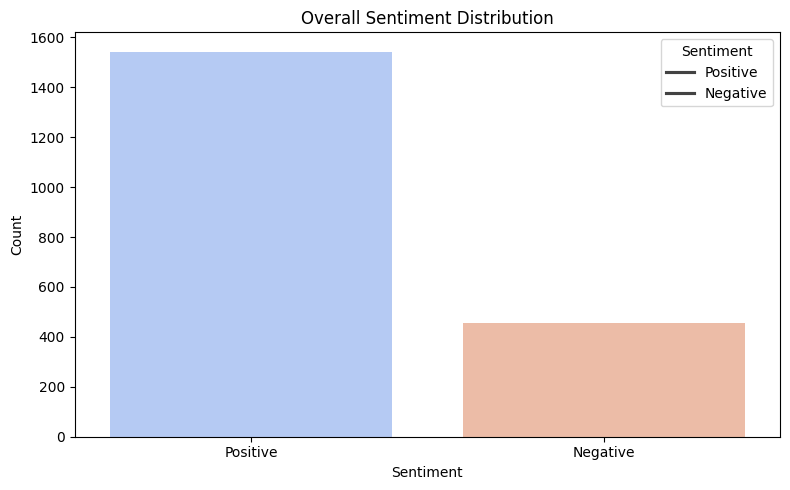

In [24]:
#draw plot for Overall Sentiment Distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_distribution.index, y=sentiment_distribution.values, palette='coolwarm')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Overall Sentiment Distribution')
plt.legend(title='Sentiment', labels=sentiment_distribution.index)
plt.tight_layout()
plt.show()

### •	Examine the distribution of sentiments across different categories and summarize your findings.

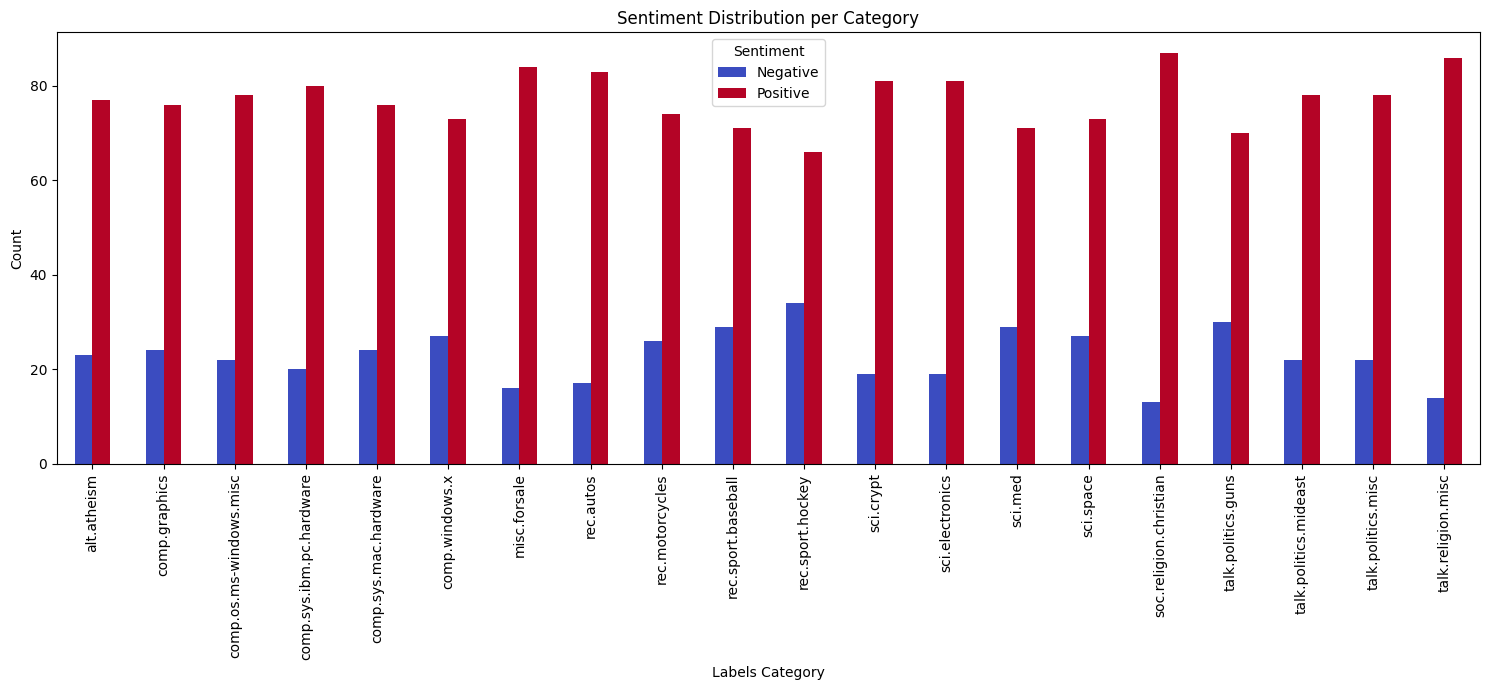

In [25]:
#draw plot distribution of sentiments across different categories
sentiment_by_label.plot(kind='bar', figsize=(15, 7), colormap='coolwarm')
plt.xlabel('Labels Category')
plt.ylabel('Count')
plt.title('Sentiment Distribution per Category')
plt.xticks(rotation=90)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

#### Data Analysis Key Findings
- Sentiment analysis using TextBlob categorized blog posts into 'Positive', 'Negative', or 'Neutral'.
- The overall sentiment distribution shows a significant majority of 'Positive' posts (1543), followed by 'Negative' posts (457). No 'Neutral' sentiments were detected.
- Across all unique 'Labels' categories, 'Positive' sentiment consistently outnumbered 'Negative' sentiment.
- Visualizations effectively illustrated both the overall sentiment distribution and the sentiment distribution within each 'Labels' category.

## 4. Evaluation

### •	Evaluate the performance of your Naive Bayes classifier using metrics such as accuracy, precision, recall, and F1-score.

In [26]:
#import evalution metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.8200
Precision: 0.8235
Recall: 0.8200
F1-Score: 0.8133


### •	Discuss the performance of the model and any challenges encountered during the classification process.

#### Naive Bayes Classifier Performance: 
The model achieved an overall accuracy of 0.8200, with weighted average precision, recall, and F1-score all around 0.82-0.83.The sentiment analysis revealed a predominant positive sentiment across the entire dataset, with 1543 posts categorized as 'Positive' and 457 as 'Negative', and no 'Neutral' posts.
This positive bias was consistent across all 20 'Labels' categories, although some categories (like rec.sport.hockey) had a relatively higher proportion of negative sentiment compared to others (like soc.religion.christian).
This suggests that, in general, the blog posts in this dataset

#### Challenges: 
The main challenge identified was the misclassification between categories with similar content, as observed in the confusion matrix (e.g., alt.atheism and talk.religion.misc, sci.electronics and comp.sys.ibm.pc.hardware). This highlights the 'naive' assumption of feature independence being a limitation for nuanced text.


### •	Reflect on the sentiment analysis results and their implications regarding the content of the blog posts.

#### Sentiment Analysis Results:
Based on the sentiment analysis, a predominant positive sentiment was observed across the dataset, with 1543 posts categorized as 'Positive' and 457 as 'Negative'. No 'Neutral' posts were detected. This positive bias was consistent across all 20 categories, though some categories like 'rec.sport.hockey' had a comparatively higher proportion of negative sentiment than others, such as 'soc.religion.christian'. This suggests that generally, the blog posts tend to express more positive opinions or discussions, with some variation depending on the specific category. This information has also been added as comments in the notebook for your reference.